env urban

csf3 junjie

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import gc
import pickle
from tqdm import tqdm
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
print("AutoML version:", AutoML.__version__)
from sklearn.inspection import permutation_importance

AutoML version: 2.1.1


In [2]:

# ====== data prep ======
# for loading CESM-LE data
def get_merge_member(start_year, end_year, parquet_save_path):
    df_tmp_ls = []
    for member_id in range(3, 34):
        member = (str(member_id).zfill(3))
        df_tmp_ls.append(pd.read_parquet(parquet_save_path + "train/" + member + "_"\
                            + start_year + "_" + end_year + ".parquet.gzip", engine="fastparquet"))
    return pd.concat(df_tmp_ls)


def get_trainning_set(input_feature, start_year, end_year):

    urban_surf_path = "/home/zhonghua/UrbFLAM/urban_params/urban_surface.parquet.gzip"
    parquet_save_path = "/home/zhonghua/UrbFLAM/urban_params/urban_LE_random_split/"
    feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }

    feature_cat =  input_feature # process from input to list
    feature_join = "_".join(feature_cat) # for file name
    feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
    print(feature_ls)

    # load data
    urban_LE = get_merge_member(start_year, end_year, parquet_save_path)
    urban_surf = pd.read_parquet(urban_surf_path, engine="fastparquet").reset_index()
    # merge data
    train = pd.merge(urban_LE, urban_surf, on = ["lat","lon"], how = "inner")
    # check if we merge the data successfully
    assert urban_LE.shape[0] == train.shape[0]
    del urban_LE, urban_surf
    gc.collect()

    return train


def get_importance(model,training_X, training_y):
    scoring = ['neg_mean_squared_error']#'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'
    r = permutation_importance(model, training_X, training_y, n_repeats=30, random_state=0, scoring=scoring)
    return r[scoring[0]].importances_mean

def get_model_ranking_score(feature_cat, model_name, start_year, training_X, training_y):
    feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
    
    end_year = str(int(start_year)+9)

    scf3home = '/home/zhonghua/UrbFLAM/urban_params'
    parquet_save_path = scf3home + "/urban_LE_random_split/"

    feature_join = "_".join(feature_cat) # for file name
    feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
    model_pkl_save_path = parquet_save_path+model_name+"/"+start_year+"_"+end_year+"_"+feature_join+".pkl"
#     print("model location:", model_pkl_save_path)
    
    with open(model_pkl_save_path, 'rb') as f:
        automl = pickle.load(f)
    #     print(automl.model.estimator)
        model = automl.model.estimator
        print(automl.model.estimator)
        #best_model_name = automl._best_estimator

    shap_importance = get_importance(model,training_X, training_y)

    df_feature = pd.DataFrame({"features":feature_ls,
                                   "importance":shap_importance})

    colname = model_name+"_"+start_year
    
    df_feature[colname] = df_feature["importance"].rank(ascending=True)
   
    return model_pkl_save_path, df_feature[["features",colname]]

## show elements of the obejct

In [3]:
%%time
feature_cat=["CAM","surf","loc"]; model_name="FLAML"; start_year="2006"
#model_pkl_save_path, df_importance = get_model_ranking_score(feature_cat, model_name, start_year)
model_pkl_save_path = '../urban_LE_random_split/xgboost/2006_2015_CAM_surf_loc.pkl'
with open(model_pkl_save_path, 'rb') as f:
    print(model_pkl_save_path)
    automl = pickle.load(f)
model = automl.model.estimator
print(automl.model.estimator)
dir(automl)


../urban_LE_random_split/xgboost/2006_2015_CAM_surf_loc.pkl
XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.4713847975226029, colsample_bynode=1,
             colsample_bytree=0.9318576757577409, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.046951447160696984,
             max_delta_step=0, max_depth=0, max_leaves=574,
             min_child_weight=20.079655627776688, missing=nan,
             monotone_constraints='()', n_estimators=15824, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
             reg_lambda=0.08622306610767176, scale_pos_weight=1,
             subsample=0.9028846964039031, tree_method='hist',
             use_label_encoder=False, validate_parameters=1, verbosity=0)
CPU times: user 23 s, sys: 5.4 s, total: 28.4 s
Wall time: 28.4 s


['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__version__',
 '__weakref__',
 '_active_estimators',
 '_auto_augment',
 '_best_estimator',
 '_best_iteration',
 '_check_feature_names',
 '_check_n_features',
 '_config_history',
 '_decide_eval_method',
 '_decide_split_type',
 '_df',
 '_early_stop',
 '_eci',
 '_ensemble',
 '_estimator_index',
 '_estimator_type',
 '_fullsize_reached',
 '_get_param_names',
 '_get_tags',
 '_hpo_method',
 '_iter_per_learner',
 '_iter_per_learner_fullsize',
 '_label_transformer',
 '_learner_selector',
 '_log_trial',
 '_log_type',
 '_max_iter',
 '_max_iter_per_learner',
 '_mem_thres',
 '_metric_constraints',
 '_min_sample_size',
 '_more_tags',
 '_n_concurrent_trials',
 '_ndim',
 '_nrow',
 '_pred_time_limit',
 '_prepare_data',
 '_preprocess',
 '_random',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_retrain_in_budget',
 '_retrained_config',
 '_sample',
 '_search',
 '_search_parallel',
 '_search_sequential',
 '_search_states',
 '_seed',
 '_select_estimator',
 '_selected',
 '_settings',
 '_split_type',
 '_start_time_flag',
 '_state',
 '_time_taken_best_iter',
 '_track_iter',
 '_trained_estimator',
 '_training_log',
 '_transformer',
 '_use_ray',
 '_validate_data',
 '_validate_ts_data',
 '_warn_threshold',
 'add_learner',
 'best_config',
 'best_config_per_estimator',
 'best_config_train_time',
 'best_estimator',
 'best_iteration',
 'best_loss',
 'best_loss_per_estimator',
 'best_model_for_estimator',
 'best_result',
 'cat_hp_cost',
 'classes_',
 'config_history',
 'data_size_full',
 'estimator_list',
 'fit',
 'get_estimator_from_log',
 'get_params',
 'low_cost_partial_config',
 'max_resource',
 'metric_constraints',
 'metrics_for_best_config',
 'min_resource',
 'model',
 'modelcount',
 'n_features_in_',
 'pickle',
 'points_to_evaluate',
 'predict',
 'predict_proba',
 'resource_attr',
 'retrain_from_log',
 'save_best_config',
 'score',
 'search_space',
 'set_params',
 'split_ratio',
 'time_to_find_best_model',
 'trainable',
 'verbose']

In [3]:
feature_cat=["CAM","surf","loc"]
feature_cat=["CAM","surf","loc"]

feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
training_set = get_trainning_set(feature_cat, "2006", '2015')

training_set_sam = training_set.groupby(['lat','lon']).sample(1, random_state=1).reset_index()

#training_X = training_set[feature_ls]
#training_y = training_set[feature_dict['label']].sample(frac=0.1, random_state=1)

['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT', 'CANYON_HWR', 'EM_IMPROAD', 'EM_PERROAD', 'EM_ROOF', 'EM_WALL', 'HT_ROOF', 'THICK_ROOF', 'THICK_WALL', 'T_BUILDING_MAX', 'T_BUILDING_MIN', 'WTLUNIT_ROOF', 'WTROAD_PERV', 'NLEV_IMPROAD', 'PCT_URBAN', 'ALB_IMPROAD', 'ALB_PERROAD', 'ALB_ROOF', 'ALB_WALL', 'TK_ROOF', 'TK_WALL', 'CV_ROOF', 'CV_WALL', 'TK_IMPROAD_0', 'CV_IMPROAD_0', 'TK_IMPROAD_1', 'CV_IMPROAD_1', 'lat', 'lon']


In [4]:
training_set_sam = training_set.groupby(['lat','lon']).sample(1, random_state=1).reset_index()
training_sam_X = training_set_sam[feature_ls]
training_sam_y = training_set_sam[feature_dict['label']]

In [18]:
scoring = ['neg_mean_squared_error']#'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'
r = permutation_importance(model, training_sam_X, training_sam_y, n_repeats=30, random_state=0, scoring=scoring)

In [11]:
r['neg_mean_squared_error'].importances_mean

array([3.72968092e+00, 3.13891925e+00, 1.02212254e+00, 1.10928744e+00,
       1.65545799e+01, 1.84212838e+02, 4.08268984e-01, 4.30529263e-01,
       8.21831346e-02, 8.06238453e-03, 0.00000000e+00, 4.27608053e-02,
       5.61679254e-02, 3.40186000e-02, 6.70861234e-02, 6.83420787e-02,
       2.51523852e-02, 6.72261010e-02, 5.11985034e-02, 4.54293708e-02,
       8.80900025e-04, 4.92247738e-01, 2.97791461e-03, 0.00000000e+00,
       3.74582579e-02, 7.79137999e-02, 4.60677971e-02, 3.89959057e-02,
       4.59555715e-02, 4.96402999e-02, 1.09941185e-02, 7.96257059e-03,
       9.65525508e-03, 6.51814342e-03, 1.86092921e+00, 1.58636400e+00])

In [5]:
get_model_ranking_score(feature_cat, "FLAML", '2006', training_sam_X, training_sam_y)

LGBMRegressor(colsample_bytree=0.5389295843070607,
              learning_rate=0.02247347321035838, max_bin=1023,
              min_child_samples=9, n_estimators=32767, num_leaves=495,
              reg_alpha=0.00706357318094864, reg_lambda=0.04950682421772725,
              verbose=-1)


('/home/zhonghua/UrbFLAM/urban_params/urban_LE_random_split/FLAML/2006_2015_CAM_surf_loc.pkl',
           features  FLAML_2006
 0             FLNS        34.0
 1             FSNS        33.0
 2            PRECT        30.0
 3             PRSN        29.0
 4             QBOT        35.0
 5           TREFHT        36.0
 6             UBOT        26.0
 7             VBOT        27.0
 8       CANYON_HWR        23.0
 9       EM_IMPROAD         7.0
 10      EM_PERROAD         1.5
 11         EM_ROOF        13.0
 12         EM_WALL        19.0
 13         HT_ROOF        10.0
 14      THICK_ROOF        22.0
 15      THICK_WALL        15.0
 16  T_BUILDING_MAX        11.0
 17  T_BUILDING_MIN        25.0
 18    WTLUNIT_ROOF        18.0
 19     WTROAD_PERV        21.0
 20    NLEV_IMPROAD         3.0
 21       PCT_URBAN        28.0
 22     ALB_IMPROAD         4.0
 23     ALB_PERROAD         1.5
 24        ALB_ROOF        20.0
 25        ALB_WALL        24.0
 26         TK_ROOF        17.0
 27      

## show feature importance of different categories

In [8]:
dd = {
    "cam":['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
    "loc":["lat","lon"],
    "morphological":['CANYON_HWR','HT_ROOF','THICK_ROOF','THICK_WALL','WTLUNIT_ROOF','WTROAD_PERV','PCT_URBAN'],
    "radiative": ['EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL'],
    "thermal":[
        'T_BUILDING_MAX','T_BUILDING_MIN',            
        'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
        'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1',
        'NLEV_IMPROAD']
}

dd_cat = {}
for key in dd:
    for feature in dd[key]:
        dd_cat[feature] = key 

In [6]:
feature_cat=["CAM","surf","loc"]

feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features

for start_year, end_year in zip(["2006", "2061"], ["2015", "2070"]):
    training_set = get_trainning_set(feature_cat, start_year, end_year)
    training_set = training_set.groupby(['lat','lon']).sample(1, random_state=1).reset_index()
    training_X = training_set[feature_ls]
    training_y = training_set[feature_dict['label']]
    for model_name in ["FLAML", "xgboost"]: #"lgbm", 
        print(start_year)
        print(model_name)
        model_pkl_save_path, df_tmp = get_model_ranking_score(feature_cat, model_name, start_year, training_X, training_y)
        if model_name == "FLAML" and start_year == "2006":
            df = df_tmp.copy()
        else:
            df = df.merge(df_tmp, on = "features", how = "outer")
        del df_tmp
        gc.collect()

['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT', 'CANYON_HWR', 'EM_IMPROAD', 'EM_PERROAD', 'EM_ROOF', 'EM_WALL', 'HT_ROOF', 'THICK_ROOF', 'THICK_WALL', 'T_BUILDING_MAX', 'T_BUILDING_MIN', 'WTLUNIT_ROOF', 'WTROAD_PERV', 'NLEV_IMPROAD', 'PCT_URBAN', 'ALB_IMPROAD', 'ALB_PERROAD', 'ALB_ROOF', 'ALB_WALL', 'TK_ROOF', 'TK_WALL', 'CV_ROOF', 'CV_WALL', 'TK_IMPROAD_0', 'CV_IMPROAD_0', 'TK_IMPROAD_1', 'CV_IMPROAD_1', 'lat', 'lon']
2006
FLAML
LGBMRegressor(colsample_bytree=0.5389295843070607,
              learning_rate=0.02247347321035838, max_bin=1023,
              min_child_samples=9, n_estimators=32767, num_leaves=495,
              reg_alpha=0.00706357318094864, reg_lambda=0.04950682421772725,
              verbose=-1)
2006
xgboost
XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.4713847975226029, colsample_bynode=1,
             colsample_bytree=0.9318576757577409, gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type='ga

In [9]:
df["category"] = df["features"].map(dd_cat)
df.to_csv("./data/feature_importance_permutation.csv",index=False)

In [2]:
df_load = pd.read_csv("./data/feature_importance_permutation.csv")
df_load

,features,FLAML_2006,xgboost_2006,FLAML_2061,xgboost_2061,category
0,FLNS,34.0,34.0,34.0,34.0,cam
1,FSNS,33.0,33.0,33.0,33.0,cam
2,PRECT,30.0,29.0,30.0,30.0,cam
3,PRSN,29.0,30.0,29.0,29.0,cam
4,QBOT,35.0,35.0,35.0,35.0,cam
5,TREFHT,36.0,36.0,36.0,36.0,cam
6,UBOT,26.0,26.0,26.0,26.0,cam
7,VBOT,27.0,27.0,27.0,27.0,cam
8,CANYON_HWR,23.0,24.0,23.0,24.0,morphological
9,EM_IMPROAD,6.0,6.0,6.0,8.0,radiative


In [3]:
df_load[["features","FLAML_2006","category"]].groupby("category").mean()

,FLAML_2006
category,
cam,31.250000
loc,31.500000
morphological,19.285714
radiative,11.000000
thermal,11.818182


## feature importance for thermal, radiative, morphological

In [4]:
df = pd.read_csv("./data/feature_importance_permutation.csv")
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]
df_plot = df_plot.replace({"xgboost":"XGBoost"})
df_plot = df_plot.replace(["cam","loc","morphological","radiative","thermal"],["CAM", "LOC", "MOR", "RAD", "THM"])

In [5]:
df_plot_tmp.model.unique()

array(['FLAML', 'xgboost'], dtype=object)

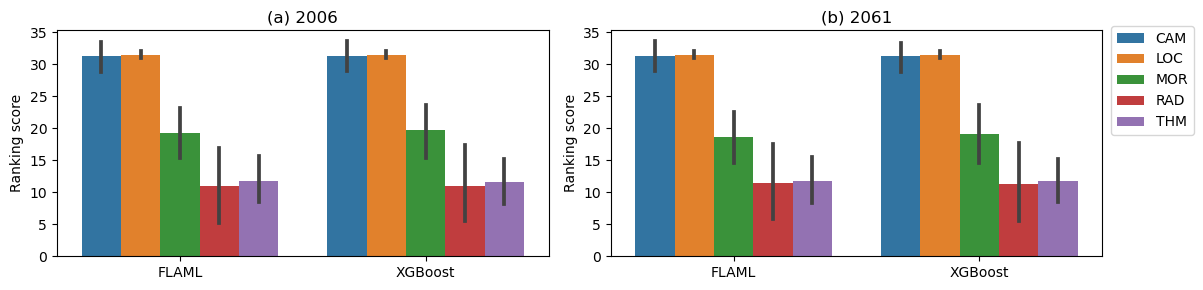

In [6]:
fig = plt.figure(figsize=(12,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.2, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('./paper_figs/permutation_importance_5.pdf', dpi=188)
plt.show()

## feature importance for surf

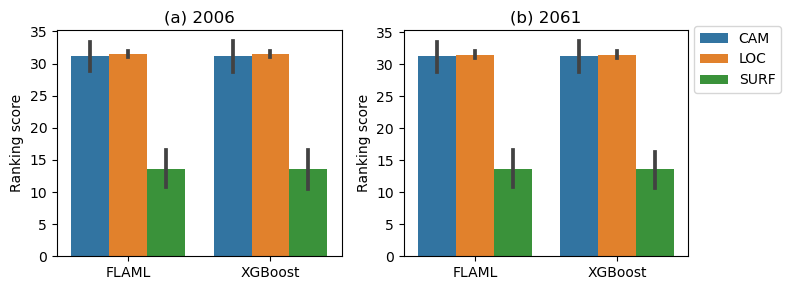

In [7]:
df = pd.read_csv("./data/feature_importance_permutation.csv").replace({"thermal":"surf", "radiative":"surf", "morphological":"surf"})
df = df.replace(["cam","loc","surf"],["CAM", "LOC", "SURF"])
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp.replace({"xgboost":"XGBoost"})
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]


fig = plt.figure(figsize=(8,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.35, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('./paper_figs/permutation_importance_3.pdf', dpi=188)
plt.show()